# Создание модели машинного обучения для классификации веществ активности

In [1]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
plt.style.use('seaborn-darkgrid')

# data preparation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

# cross-validation
from sklearn.model_selection import cross_val_score

#scores
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


## Загрузка данных

Получение, очистку данных, и выбор значимых дескрипторов см. в `1_DataPreparationAndEDA.ipynb`

In [2]:
df = pd.read_csv("final_activities.csv")
df

,canonical_smiles,molecule_chembl_id,activity_class,document_year,pIC50,MW,LogP,NumDonors,NumAcceptors,NumSatHet,NumArHet,NumRotBonds,MaxAEI,MaxEI,MinEI
0,CSc1ncnc2c1NCN2CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4...,CHEMBL591237,non-active,2010,-4.000002,480.678,5.1051,1.0,7.0,0.0,1.0,4.0,13.748208,13.748208,0.103571
1,Fc1cccc(Cl)c1/C=N/N=C1c2ccccc2-c2ccccc21,CHEMBL601298,non-active,2010,-4.000001,334.781,5.3310,0.0,2.0,0.0,0.0,2.0,13.804850,13.804850,-0.417896
2,CCOC(=O)CN(C(=O)COC(=O)Cc1c[nH]c2ccccc12)c1ccc...,CHEMBL601283,non-active,2010,-4.000000,412.417,2.9890,1.0,5.0,0.0,1.0,8.0,13.212795,13.212795,-0.624728
3,CCOc1cccc2cc(C(=O)OCC(=O)c3c[nH]c4ccccc34)c(=O...,CHEMBL591964,non-active,2010,-4.000001,391.379,3.7127,1.0,6.0,0.0,2.0,6.0,12.454092,12.454092,-0.920691
4,CCOc1cccc2cc(C(=O)OCC(=O)c3c[nH]c4ccccc34)c(=O...,CHEMBL591964,non-active,2010,-4.000001,391.379,3.7127,1.0,6.0,0.0,2.0,6.0,12.454092,12.454092,-0.920691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,CC(=O)O[C@H]1CC[C@@]2(C)[C@@H](CC[C@]3(C)[C@@H...,CHEMBL4644911,non-active,2020,-4.000004,514.747,6.7752,2.0,4.0,0.0,0.0,2.0,12.889766,12.889766,-1.029232
492,CO[C@@H]1C[C@@]2(C)[C@@H](CC[C@]3(C)[C@@H]2CC=...,CHEMBL4647916,non-active,2020,-4.000004,502.736,6.4425,2.0,4.0,1.0,0.0,2.0,12.898040,12.898040,-1.020090
493,CC(C)c1cc2c(cc1O)CC[C@H]1[C@@](C)(CO)CCC[C@]21C,CHEMBL4642797,non-active,2020,-4.000004,302.458,4.5182,2.0,2.0,0.0,0.0,2.0,10.325770,10.325770,0.042232
494,C=C1C(=O)[C@]23C[C@H]1CC[C@H]2[C@]1(C)CC[C@@H]...,CHEMBL4636385,non-active,2020,-4.000004,318.457,3.0960,2.0,3.0,0.0,0.0,0.0,13.086868,13.086868,-0.579740


## Проверка данных
### Матрица корреляции

Построим матрицу корреляции с целью проверить, нет ли таких признаков которые сильно коррелируют и следовательно могут быть отброшены.

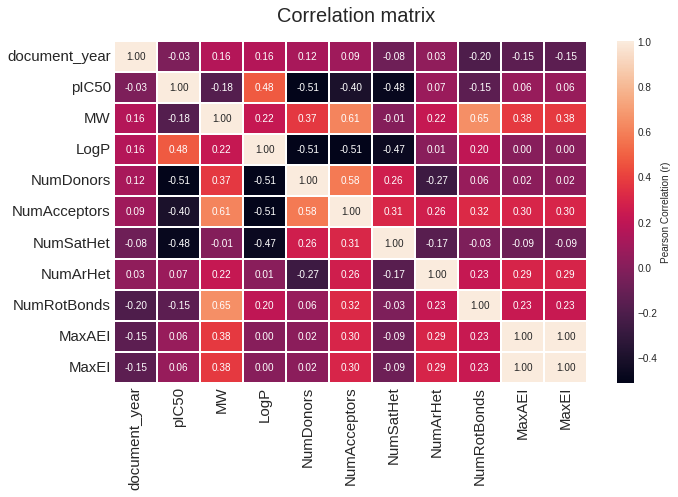

In [3]:
plt.figure(figsize=(10,7))
plt.suptitle("Correlation matrix", size=20)
corr_mat = df.iloc[:,:-1].corr()
sns.heatmap(corr_mat, fmt='0.2f', annot=True, lw=2, cbar_kws={'label':'Pearson Correlation (r)'})
plt.xticks(size=15,rotation=90)
plt.yticks(size=15,rotation=0)
plt.tight_layout()
plt.savefig('imgs/CorrelationMatrix.png',dpi=300);

Видим, что все фичи достаточно слабо коррелируют, за исключением MaxAEI и MaxEI. Это говорит о том что положительные EState indexes по модулю больше отрицательных, и о том что MaxAEI можно отбросить. 

In [4]:
df = df.drop(columns=['MaxAEI'])
df

,canonical_smiles,molecule_chembl_id,activity_class,document_year,pIC50,MW,LogP,NumDonors,NumAcceptors,NumSatHet,NumArHet,NumRotBonds,MaxEI,MinEI
0,CSc1ncnc2c1NCN2CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4...,CHEMBL591237,non-active,2010,-4.000002,480.678,5.1051,1.0,7.0,0.0,1.0,4.0,13.748208,0.103571
1,Fc1cccc(Cl)c1/C=N/N=C1c2ccccc2-c2ccccc21,CHEMBL601298,non-active,2010,-4.000001,334.781,5.3310,0.0,2.0,0.0,0.0,2.0,13.804850,-0.417896
2,CCOC(=O)CN(C(=O)COC(=O)Cc1c[nH]c2ccccc12)c1ccc...,CHEMBL601283,non-active,2010,-4.000000,412.417,2.9890,1.0,5.0,0.0,1.0,8.0,13.212795,-0.624728
3,CCOc1cccc2cc(C(=O)OCC(=O)c3c[nH]c4ccccc34)c(=O...,CHEMBL591964,non-active,2010,-4.000001,391.379,3.7127,1.0,6.0,0.0,2.0,6.0,12.454092,-0.920691
4,CCOc1cccc2cc(C(=O)OCC(=O)c3c[nH]c4ccccc34)c(=O...,CHEMBL591964,non-active,2010,-4.000001,391.379,3.7127,1.0,6.0,0.0,2.0,6.0,12.454092,-0.920691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,CC(=O)O[C@H]1CC[C@@]2(C)[C@@H](CC[C@]3(C)[C@@H...,CHEMBL4644911,non-active,2020,-4.000004,514.747,6.7752,2.0,4.0,0.0,0.0,2.0,12.889766,-1.029232
492,CO[C@@H]1C[C@@]2(C)[C@@H](CC[C@]3(C)[C@@H]2CC=...,CHEMBL4647916,non-active,2020,-4.000004,502.736,6.4425,2.0,4.0,1.0,0.0,2.0,12.898040,-1.020090
493,CC(C)c1cc2c(cc1O)CC[C@H]1[C@@](C)(CO)CCC[C@]21C,CHEMBL4642797,non-active,2020,-4.000004,302.458,4.5182,2.0,2.0,0.0,0.0,2.0,10.325770,0.042232
494,C=C1C(=O)[C@]23C[C@H]1CC[C@H]2[C@]1(C)CC[C@@H]...,CHEMBL4636385,non-active,2020,-4.000004,318.457,3.0960,2.0,3.0,0.0,0.0,0.0,13.086868,-0.579740


### Распределение классов
Проверим распределение классов в датасете и при необходимости выровняем их количество

/home/someanonimcoder/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


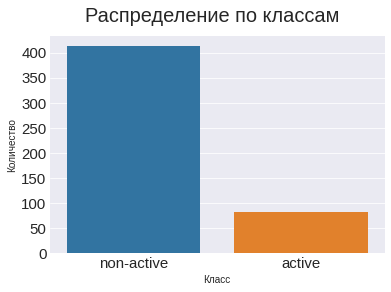

In [5]:
sns.countplot(df.activity_class, label="Количество")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.xticks(size=15)
plt.yticks(size=15)
sns.despine(top=True)
plt.suptitle("Распределение по классам", size=20)
plt.savefig('imgs/Classes.png');

## Подготовка данных для обучения

Закодируем класс активности(активно - неактивно) как 0/1, выберем фичи в X и целевое значение в y, исправим классовый дисбаланс.

In [6]:
# encode activity_class as integer
df['activity_class'] = df.activity_class.map({"active":1, "non-active":0})

In [7]:
# X and y selection
X = df[[
    'MW', 
    'LogP', 
    'NumDonors', 
    'NumAcceptors',
    'NumSatHet', 
    'NumArHet', 
    'NumRotBonds', 
    'MaxEI', 
    'MinEI']
]

y = df['activity_class']

# train and test split + stratification
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1337)


/home/someanonimcoder/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='activity_class', ylabel='count'>

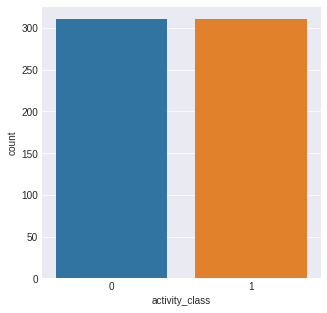

In [8]:
rs = SMOTE(sampling_strategy='auto')
X_train,y_train = rs.fit_resample(X_train,y_train)

plt.figure(figsize=(5,5))
sns.countplot(y_train)


In [9]:
# для осмысленных названий фич в барплотах важности
data_features = [x for i,x in enumerate(X.columns)]

## Обучение
### KNN - метод k ближайших соседей


In [10]:
acc_train = []
acc_test = []
f1_train = []
f1_test = []

neighbour_counts = range(3,20)

for count in neighbour_counts:
    knn = KNeighborsClassifier(n_neighbors=count)
    knn.fit(X_train, y_train)
    
    pred_train = knn.predict(X_train)
    train_f1 = f1_score(pred_train, y_train)
    train_acc = accuracy_score(pred_train, y_train)
    
    pred_test = knn.predict(X_test)
    test_f1 = f1_score(pred_test, y_test)
    test_acc = accuracy_score(pred_test, y_test)
    
    acc_train.append(train_acc)
    acc_test.append(test_acc)
    f1_train.append(train_f1)
    f1_test.append(test_f1)

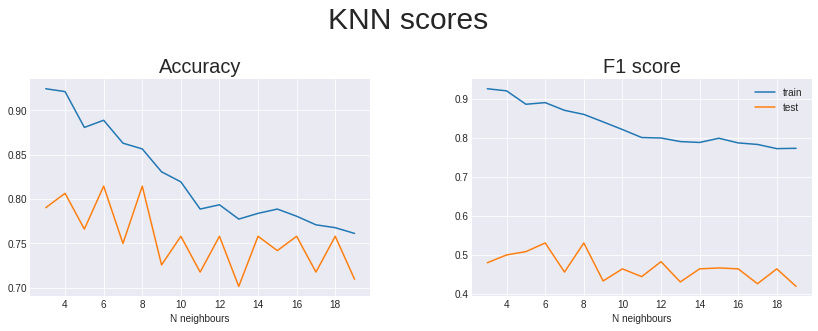

In [11]:
fig = plt.figure(figsize=[14,10])
fig.subplots_adjust(hspace=0.5, wspace=0.3)

fig.add_subplot(2,2,1)
plt.title("Accuracy", size=20)
plt.plot(neighbour_counts, acc_train, label="train")
plt.plot(neighbour_counts, acc_test, label="test")
plt.xlabel("N neighbours")


fig.add_subplot(2,2,2)
plt.title("F1 score", size=20)
plt.plot(neighbour_counts, f1_train, label="train")
plt.plot(neighbour_counts, f1_test, label="test")
plt.xlabel("N neighbours")

plt.suptitle("KNN scores", size=30)
plt.legend()
plt.savefig('imgs/KNN_scores.png');

Судя по точности и F1, оптимальное количество соседей для нашей задачи - 6

In [12]:
knn = KNeighborsClassifier(n_neighbors=count)
knn.fit(X_train, y_train)
    
pred_train = knn.predict(X_train)
train_f1 = f1_score(pred_train, y_train)
train_acc = accuracy_score(pred_train, y_train)
    
pred_test = knn.predict(X_test)
knn_test_f1 = f1_score(pred_test, y_test)
knn_test_acc = accuracy_score(pred_test, y_test)

print(f"""
Точность на тестовом наборе: {test_acc:.2f}
Точность на тренировочном наборе: {train_acc:.2f}
F1 на тестовом наборе: {knn_test_f1:.2f}
""")


Точность на тестовом наборе: 0.71
Точность на тренировочном наборе: 0.76
F1 на тестовом наборе: 0.42



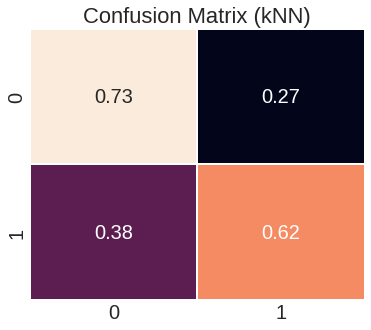

In [13]:
def plot_confusion_matrix(y_test, conf_mat, model):
    _ , counts = np.unique(y_test,return_counts=True)
    conf_mat = (conf_mat.T/counts).T
    plt.figure(figsize=(6,5))
    ax=sns.heatmap(conf_mat,fmt='.2f',annot=True,
                   annot_kws={'size':20},cbar=False, lw=2)
    plt.title(f'Confusion Matrix ({model})',size=22)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel='real'
    plt.xlabel='predicted'
    plt.savefig(f'imgs/{model}_conf.png')


conf_mat = confusion_matrix(y_test,pred_test)
plot_confusion_matrix(y_test,conf_mat, 'kNN')


#### k-fold кроссвалидация


In [14]:
k_fold_knn_acc = cross_val_score(knn, X, y, cv=10) ##10-fold cross validation
k_fold_knn_f1 = cross_val_score(knn, X, y, cv=10,scoring='f1_weighted') ##10-fold cross validation
print(f"""Точность KNN с кросс-валидацией: {k_fold_knn_acc.mean():.2f}, std: {k_fold_knn_acc.std():.2f}
F1 KNN с кросс-валидацией: {k_fold_knn_f1.mean():.2f}, std: {k_fold_knn_f1.std():.2f}
""")

Точность KNN с кросс-валидацией: 0.81, std: 0.04
F1 KNN с кросс-валидацией: 0.75, std: 0.02



### Gradient Boost



In [15]:
gb = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
pred_test=gb.predict(X_test)


print(f"""
Точность на тестовом наборе: {gb.score(X_test, y_test):.2f}
Точность на тренировочном наборе: {gb.score(X_train, y_train):.2f}
F1 на тестовом наборе: {f1_score(pred_test, y_test):.2f}
""")


Точность на тестовом наборе: 0.84
Точность на тренировочном наборе: 0.99
F1 на тестовом наборе: 0.58



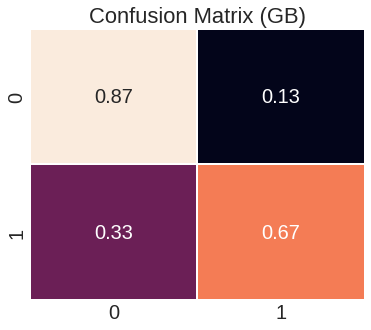

In [16]:
conf_mat = confusion_matrix(y_test,pred_test)
plot_confusion_matrix(y_test,conf_mat, 'GB')

Хотя GB показал себя лучше, чем kNN, хорошо видно переобучение, результат на тестовом наборе сильно ниже чем на обучающем. Попробуем исправить ситуацию кроссвалидацией
#### Кроссвалидация

In [17]:
k_fold_gb_acc = cross_val_score(gb, X, y, cv=10) ##10-fold cross validation
k_fold_gb_f1 = cross_val_score(gb, X, y, cv=10, scoring="f1_weighted") ##10-fold cross validation

print(f"""Точность GB с кросс-валидацией: {k_fold_gb_acc.mean():.2f}, std: {k_fold_gb_acc.std():.2f}
F1 GB с кросс-валидацией: {k_fold_gb_f1.mean():.2f}, std: {k_fold_gb_f1.std():.2f}
""")

Точность GB с кросс-валидацией: 0.81, std: 0.13
F1 GB с кросс-валидацией: 0.81, std: 0.11



#### Важность признаков



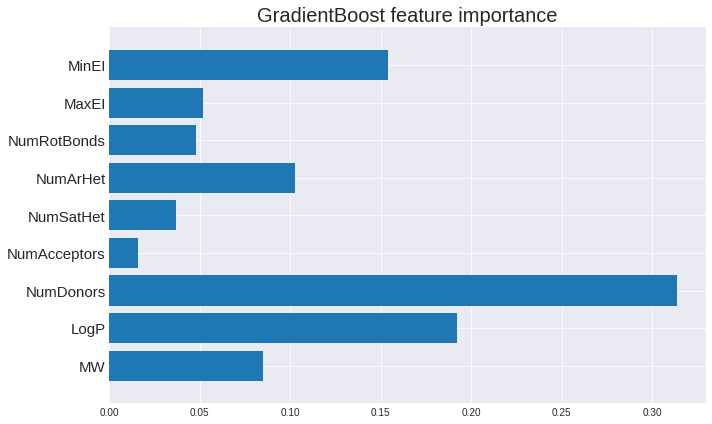

In [18]:
def plot_feature_importances(model, model_name):
    n_features = len(data_features)
    plt.figure(figsize=(10,6))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data_features,size=15)
    plt.ylim(-1, n_features)
    sns.despine(top=True)
    plt.title(f"{model_name} feature importance", size=20)
    plt.tight_layout()
    plt.savefig(f'imgs/{model_name}_feature_imp.png')

    
plot_feature_importances(gb, "GradientBoost")

### CatBoost

In [19]:
cb = CatBoostClassifier(iterations=30,
                           learning_rate=1,
                           depth=7)
cb.fit(X_train, y_train)

pred_test=cb.predict(X_test)

print(f"""
Точность на тестовом наборе: {cb.score(X_test, y_test):.2f}
Точность на тренировочном наборе: {cb.score(X_train, y_train):.2f}
F1 на тестовом наборе: {f1_score(pred_test, y_test):.2f}
""")

0:	learn: 0.3988721	total: 48.3ms	remaining: 1.4s
1:	learn: 0.3172478	total: 50ms	remaining: 700ms
2:	learn: 0.2477854	total: 51.5ms	remaining: 464ms
3:	learn: 0.2199098	total: 53.3ms	remaining: 346ms
4:	learn: 0.1847143	total: 55.5ms	remaining: 278ms
5:	learn: 0.1616287	total: 57.1ms	remaining: 229ms
6:	learn: 0.1524378	total: 58.7ms	remaining: 193ms
7:	learn: 0.1409531	total: 60.6ms	remaining: 167ms
8:	learn: 0.1282542	total: 62.9ms	remaining: 147ms
9:	learn: 0.1217088	total: 64.5ms	remaining: 129ms
10:	learn: 0.1116538	total: 65.9ms	remaining: 114ms
11:	learn: 0.1039084	total: 67.5ms	remaining: 101ms
12:	learn: 0.0962817	total: 69.7ms	remaining: 91.1ms
13:	learn: 0.0865163	total: 71.2ms	remaining: 81.3ms
14:	learn: 0.0809452	total: 72.5ms	remaining: 72.5ms
15:	learn: 0.0773656	total: 73.9ms	remaining: 64.6ms
16:	learn: 0.0705625	total: 75ms	remaining: 57.4ms
17:	learn: 0.0658459	total: 76.4ms	remaining: 50.9ms
18:	learn: 0.0626612	total: 77.6ms	remaining: 44.9ms
19:	learn: 0.0609659

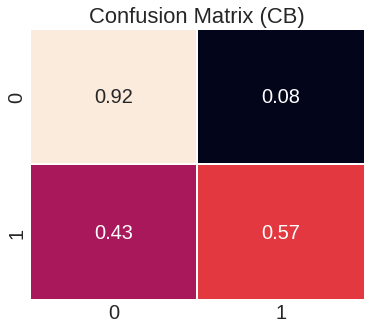

In [20]:
conf_mat = confusion_matrix(y_test,pred_test)
plot_confusion_matrix(y_test,conf_mat, 'СB')

#### Кроссвалидация
CatBoost показал меньшее переобучение чем GB, но все равно посмотрим что будет с кроссвалидацией

In [21]:
k_fold_cb_acc = cross_val_score(cb, X, y, cv=10) ##10-fold cross validation
k_fold_cb_f1 = cross_val_score(cb, X, y, cv=10, scoring="f1_weighted") ##10-fold cross validation

print(f"""Точность СB с кросс-валидацией: {k_fold_cb_acc.mean():.2f}, std: {k_fold_cb_acc.std():.2f}
F1 СB с кросс-валидацией: {k_fold_cb_f1.mean():.2f}, std: {k_fold_cb_f1.std():.2f}
""")

0:	learn: 0.3924269	total: 1.57ms	remaining: 45.5ms
1:	learn: 0.2846565	total: 2.81ms	remaining: 39.3ms
2:	learn: 0.2481251	total: 3.85ms	remaining: 34.6ms
3:	learn: 0.2151779	total: 4.97ms	remaining: 32.3ms
4:	learn: 0.1996828	total: 6.08ms	remaining: 30.4ms
5:	learn: 0.1787096	total: 7.07ms	remaining: 28.3ms
6:	learn: 0.1740730	total: 8.1ms	remaining: 26.6ms
7:	learn: 0.1615884	total: 9.12ms	remaining: 25.1ms
8:	learn: 0.1530202	total: 10.1ms	remaining: 23.6ms
9:	learn: 0.1455660	total: 11.1ms	remaining: 22.3ms
10:	learn: 0.1399240	total: 12.2ms	remaining: 21.1ms
11:	learn: 0.1358247	total: 13.2ms	remaining: 19.8ms
12:	learn: 0.1313223	total: 14.2ms	remaining: 18.5ms
13:	learn: 0.1271876	total: 15.2ms	remaining: 17.3ms
14:	learn: 0.1259965	total: 16.1ms	remaining: 16.1ms
15:	learn: 0.1231117	total: 17.3ms	remaining: 15.1ms
16:	learn: 0.1210796	total: 18.7ms	remaining: 14.3ms
17:	learn: 0.1098361	total: 19.8ms	remaining: 13.2ms
18:	learn: 0.1088829	total: 20.8ms	remaining: 12ms
19:	le

6:	learn: 0.1723516	total: 7.6ms	remaining: 25ms
7:	learn: 0.1625870	total: 8.84ms	remaining: 24.3ms
8:	learn: 0.1603807	total: 9.96ms	remaining: 23.2ms
9:	learn: 0.1596431	total: 10.5ms	remaining: 21ms
10:	learn: 0.1570048	total: 11.6ms	remaining: 20.1ms
11:	learn: 0.1553268	total: 12.7ms	remaining: 19.1ms
12:	learn: 0.1544762	total: 13.9ms	remaining: 18.2ms
13:	learn: 0.1527715	total: 14.9ms	remaining: 17ms
14:	learn: 0.1515142	total: 15.8ms	remaining: 15.8ms
15:	learn: 0.1392292	total: 16.8ms	remaining: 14.7ms
16:	learn: 0.1339736	total: 17.9ms	remaining: 13.7ms
17:	learn: 0.1330162	total: 18.9ms	remaining: 12.6ms
18:	learn: 0.1322123	total: 19.9ms	remaining: 11.5ms
19:	learn: 0.1315058	total: 21ms	remaining: 10.5ms
20:	learn: 0.1309098	total: 22ms	remaining: 9.42ms
21:	learn: 0.1278409	total: 23.1ms	remaining: 8.38ms
22:	learn: 0.1271419	total: 24.1ms	remaining: 7.33ms
23:	learn: 0.1232529	total: 25.1ms	remaining: 6.28ms
24:	learn: 0.1154145	total: 26.2ms	remaining: 5.23ms
25:	lear

1:	learn: 0.3003832	total: 2.38ms	remaining: 33.3ms
2:	learn: 0.2574039	total: 3.6ms	remaining: 32.4ms
3:	learn: 0.2363132	total: 4.75ms	remaining: 30.9ms
4:	learn: 0.2243067	total: 5.88ms	remaining: 29.4ms
5:	learn: 0.2086071	total: 6.9ms	remaining: 27.6ms
6:	learn: 0.2009135	total: 7.89ms	remaining: 25.9ms
7:	learn: 0.1880872	total: 8.85ms	remaining: 24.3ms
8:	learn: 0.1654513	total: 10ms	remaining: 23.4ms
9:	learn: 0.1637075	total: 11ms	remaining: 22ms
10:	learn: 0.1504398	total: 12ms	remaining: 20.8ms
11:	learn: 0.1485707	total: 13ms	remaining: 19.6ms
12:	learn: 0.1407877	total: 14ms	remaining: 18.4ms
13:	learn: 0.1369226	total: 15ms	remaining: 17.2ms
14:	learn: 0.1353225	total: 16ms	remaining: 16ms
15:	learn: 0.1343004	total: 16.9ms	remaining: 14.8ms
16:	learn: 0.1327250	total: 17.9ms	remaining: 13.7ms
17:	learn: 0.1316951	total: 19ms	remaining: 12.6ms
18:	learn: 0.1240644	total: 20ms	remaining: 11.6ms
19:	learn: 0.1186114	total: 21ms	remaining: 10.5ms
20:	learn: 0.1086397	total: 

Кроссвалидация заметно улучшила F1, почти не отразившись на точности

#### Важность признаков

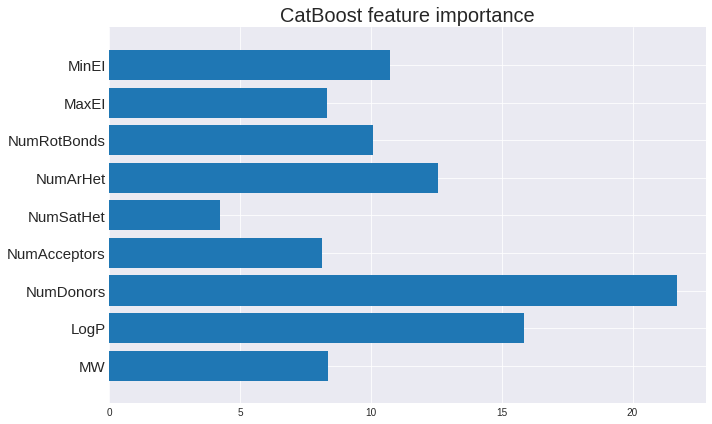

In [22]:
plot_feature_importances(cb, "CatBoost")

## Random Forest

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

pred_test=rf.predict(X_test)

print(f"""
Точность на тестовом наборе: {rf.score(X_test, y_test):.2f}
Точность на тренировочном наборе: {rf.score(X_train, y_train):.2f}
F1 на тестовом наборе: {f1_score(pred_test, y_test):.2f}
""")


Точность на тестовом наборе: 0.85
Точность на тренировочном наборе: 0.99
F1 на тестовом наборе: 0.58



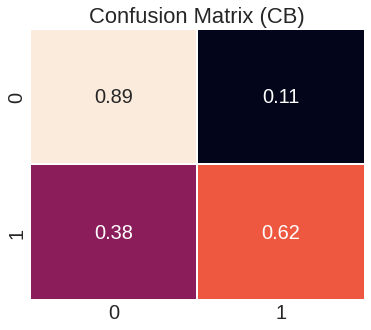

In [24]:
conf_mat = confusion_matrix(y_test,pred_test)
plot_confusion_matrix(y_test,conf_mat, 'СB')

In [25]:
k_fold_rf_acc = cross_val_score(rf, X, y, cv=10) ##10-fold cross validation
k_fold_rf_f1 = cross_val_score(rf, X, y, cv=10, scoring="f1_weighted") ##10-fold cross validation

print(f"""Точность RF с кросс-валидацией: {k_fold_rf_acc.mean():.2f}, std: {k_fold_rf_acc.std():.2f}
F1 RF с кросс-валидацией: {k_fold_rf_f1.mean():.2f}, std: {k_fold_rf_f1.std():.2f}
""")

Точность RF с кросс-валидацией: 0.83, std: 0.11
F1 RF с кросс-валидацией: 0.82, std: 0.10



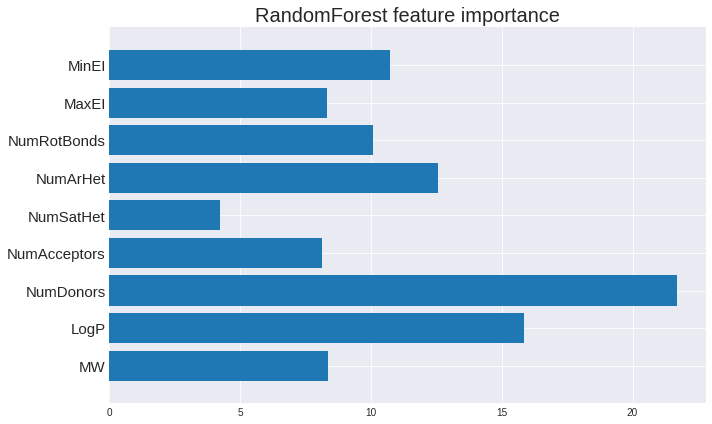

In [26]:
plot_feature_importances(cb, "RandomForest")

## AdaBoost


In [27]:
ab = AdaBoostClassifier(n_estimators=100)
ab.fit(X_train, y_train)

pred_test=ab.predict(X_test)

print(f"""
Точность на тестовом наборе: {ab.score(X_test, y_test):.2f}
Точность на тренировочном наборе: {ab.score(X_train, y_train):.2f}
F1 на тестовом наборе: {f1_score(pred_test, y_test):.2f}
""")


Точность на тестовом наборе: 0.85
Точность на тренировочном наборе: 0.98
F1 на тестовом наборе: 0.63



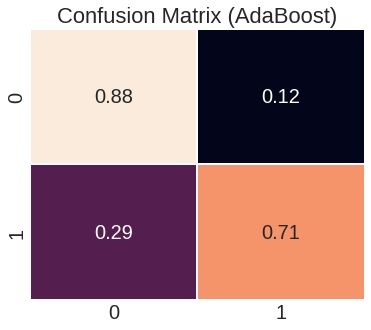

In [28]:
conf_mat = confusion_matrix(y_test,pred_test)
plot_confusion_matrix(y_test,conf_mat, 'AdaBoost')

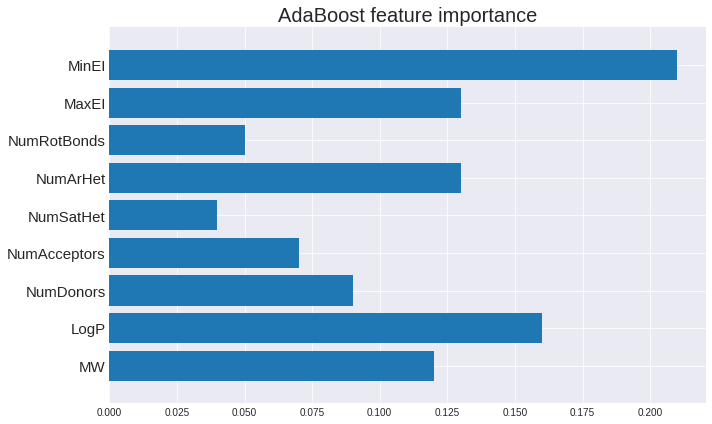

In [29]:
plot_feature_importances(ab, "AdaBoost")

In [30]:
k_fold_ab_acc = cross_val_score(rf, X, y, cv=10) ##10-fold cross validation
k_fold_ab_f1 = cross_val_score(rf, X, y, cv=10, scoring="f1_weighted") ##10-fold cross validation

print(f"""Точность AdaBoost с кросс-валидацией: {k_fold_ab_acc.mean():.2f}, std: {k_fold_ab_acc.std():.2f}
F1 AdaBoost с кросс-валидацией: {k_fold_ab_f1.mean():.2f}, std: {k_fold_ab_f1.std():.2f}
""")

Точность AdaBoost с кросс-валидацией: 0.82, std: 0.11
F1 AdaBoost с кросс-валидацией: 0.83, std: 0.10



# CART


In [31]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

pred_test=dt.predict(X_test)

print(f"""
Точность на тестовом наборе: {dt.score(X_test, y_test):.2f}
Точность на тренировочном наборе: {dt.score(X_train, y_train):.2f}
F1 на тестовом наборе: {f1_score(pred_test, y_test):.2f}
""")


Точность на тестовом наборе: 0.81
Точность на тренировочном наборе: 0.99
F1 на тестовом наборе: 0.50



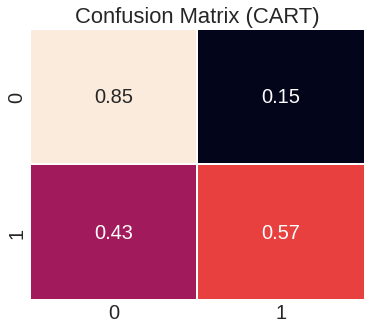

In [32]:
conf_mat = confusion_matrix(y_test,pred_test)
plot_confusion_matrix(y_test,conf_mat, 'CART')

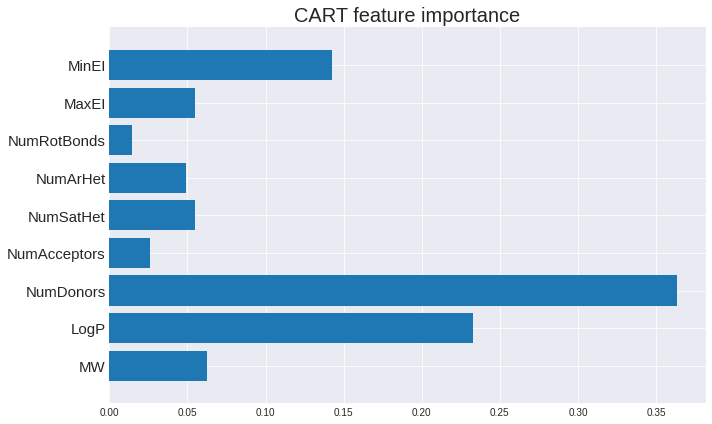

In [33]:
plot_feature_importances(dt, "CART")

In [34]:
k_fold_dt_acc = cross_val_score(dt, X, y, cv=10) ##10-fold cross validation
k_fold_dt_f1 = cross_val_score(dt, X, y, cv=10, scoring="f1_weighted") ##10-fold cross validation

print(f"""Точность CART с кросс-валидацией: {k_fold_dt_acc.mean():.2f}, std: {k_fold_dt_acc.std():.2f}
F1 CART с кросс-валидацией: {k_fold_dt_f1.mean():.2f}, std: {k_fold_dt_f1.std():.2f}
""")

Точность CART с кросс-валидацией: 0.69, std: 0.19
F1 CART с кросс-валидацией: 0.76, std: 0.11



# SVM

In [35]:
svm = SVC()
svm.fit(X_train, y_train)

pred_test=svm.predict(X_test)

print(f"""
Точность на тестовом наборе: {svm.score(X_test, y_test):.2f}
Точность на тренировочном наборе: {svm.score(X_train, y_train):.2f}
F1 на тестовом наборе: {f1_score(pred_test, y_test):.2f}
""")


Точность на тестовом наборе: 0.60
Точность на тренировочном наборе: 0.63
F1 на тестовом наборе: 0.31



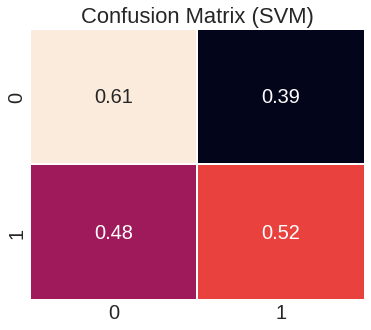

In [36]:
conf_mat = confusion_matrix(y_test,pred_test)
plot_confusion_matrix(y_test,conf_mat, 'SVM')

In [37]:
k_fold_svm_acc = cross_val_score(svm, X, y, cv=10) ##10-fold cross validation
k_fold_svm_f1 = cross_val_score(svm, X, y, cv=10, scoring="f1_weighted") ##10-fold cross validation

print(f"""Точность SVM с кросс-валидацией: {k_fold_svm_acc.mean():.2f}, std: {k_fold_svm_acc.std():.2f}
F1 SVM с кросс-валидацией: {k_fold_svm_f1.mean():.2f}, std: {k_fold_svm_f1.std():.2f}
""")

Точность SVM с кросс-валидацией: 0.83, std: 0.01
F1 SVM с кросс-валидацией: 0.76, std: 0.01



# Анализ результатов и выводы

Соберем результаты всех моделей в один датафрейм и проанализируем их

In [38]:
all_models = ['KNN', 'GradientBoost', 'CatBoost', 'AdaBoost', 
              'RandomForest', 'CART', 'SVM']
accuracies = [k_fold_knn_acc.mean(), k_fold_gb_acc.mean(), 
              k_fold_cb_acc.mean(), k_fold_ab_acc.mean(),
              k_fold_rf_acc.mean(), k_fold_dt_acc.mean(),
              k_fold_svm_acc.mean()]

f1_scores = [k_fold_knn_f1.mean(), k_fold_gb_f1.mean(), 
             k_fold_cb_f1.mean(),k_fold_ab_f1.mean(),
             k_fold_rf_f1.mean(),k_fold_dt_f1.mean(),
            k_fold_svm_f1.mean()]

data=np.array([all_models,accuracies, f1_scores]).T
result_df = pd.DataFrame(data, columns=['model', 'accuracy', 'f1'])
result_df.accuracy = result_df.accuracy.astype(float)
result_df.f1 = result_df.f1.astype(float)
result_df

,model,accuracy,f1
0,KNN,0.812531,0.747839
1,GradientBoost,0.810163,0.810706
2,CatBoost,0.848204,0.844399
3,AdaBoost,0.824122,0.826573
4,RandomForest,0.828041,0.820148
5,CART,0.692939,0.760052
6,SVM,0.832694,0.756701


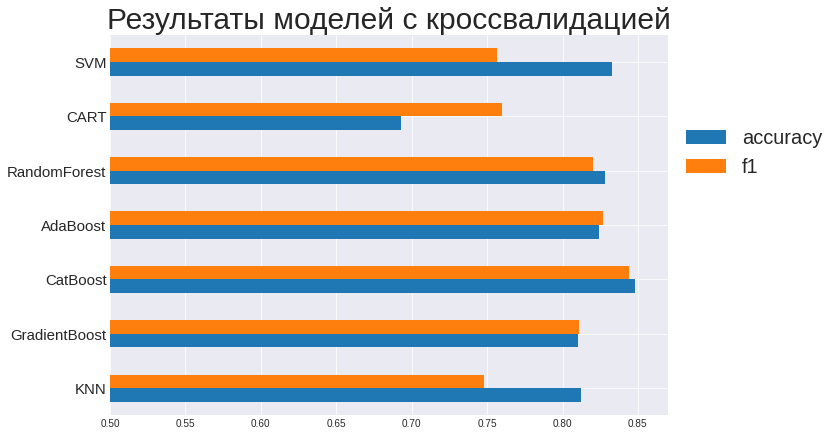

In [39]:
result_df.plot.barh(figsize=[10,7])
plt.legend(frameon=False,bbox_to_anchor=(1,0.8), prop={'size':20})
plt.yticks(np.arange(len(result_df)), result_df.model.to_numpy(), size=15)
plt.xlim([0.5,0.87]);
plt.title("Результаты моделей с кроссвалидацией", size=30)
sns.despine(top=True)
plt.savefig('imgs/Results.png')

Лучшей моделью по итогам тестов оказался CatBoost; AdaBoost, RandomForest, GradientBoost не сильно от него отстают. Остальные модели оказались существенно хуже по точности, F1, или им обоим сразу.

# To be continued

Сейчас все модели запущены с дефолтными параметрами. Возможно после оптимизации гиперпараметров часть моделей станет заметно лучше, надо будет проверить